In [2]:
import sys
print(sys.executable)



C:\Users\akila\AppData\Local\Programs\Python\Python313\python.exe


In [ ]:
import sys
!{sys.executable} -m pip install numpy pandas matplotlib seaborn statsmodels scikit-learn torch


In [2]:
import sys
print(sys.executable)


C:\Users\akila\AppData\Local\Programs\Python\Python313\python.exe


In [3]:
import sys
!{sys.executable} -m pip install numpy pandas matplotlib seaborn statsmodels scikit-learn torch


  Using cached numpy-2.3.5-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached pandas-2.3.3-cp313-cp313-win_amd64.whl.metadata (19 kB)
  Using cached matplotlib-3.10.7-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached statsmodels-0.14.5-cp313-cp313-win_amd64.whl.metadata (9.8 kB)
  Using cached scikit_learn-1.7.2-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached torch-2.9.1-cp313-cp313-win_amd64.whl.metadata (30 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp313-cp313-win_amd64.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
  Using cached pillow-12.0.0-cp313-cp313-win_amd64.whl.metadata (9.0 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: C:\Users\akila\AppData\Local\Programs\Python\Python313\python.exe -m pip install --upgrade pip


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn

import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing

device = "cuda" if torch.cuda.is_available() else "cpu"


In [5]:

data = sm.datasets.co2.load_pandas().data.reset_index()
data.columns = ['date', 'value']
data = data.dropna()
data['value'] = data['value'].astype(float)
data = data.set_index('date')


--- ADF TEST ---
ADF Statistic: 0.043964668206229914
p-value: 0.9620203942307848

--- KPSS TEST ---
KPSS Statistic: 7.464952507406259
p-value: 0.01


C:\Users\akila\AppData\Local\Temp\ipykernel_6020\1135395049.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), nlags="auto")


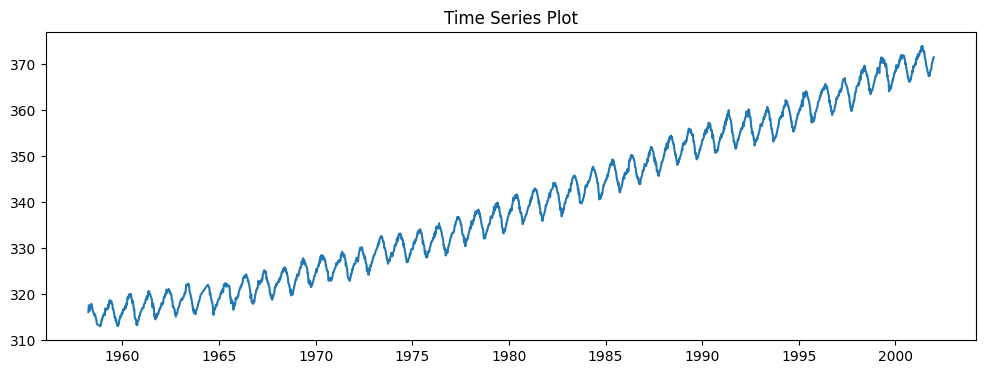

In [6]:

def adf_test(series):
    result = adfuller(series.dropna())
    print("\n--- ADF TEST ---")
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])

def kpss_test(series):
    result = kpss(series.dropna(), nlags="auto")
    print("\n--- KPSS TEST ---")
    print("KPSS Statistic:", result[0])
    print("p-value:", result[1])

adf_test(data['value'])
kpss_test(data['value'])

plt.figure(figsize=(12,4))
plt.plot(data.value)
plt.title("Time Series Plot")
plt.show()

In [8]:

scaler = MinMaxScaler()
scaled = scaler.fit_transform(data[['value']])

SEQ_LEN = 48   # input length
PRED_LEN = 12  # forecast length

def create_sequences(values, seq_length, pred_length):
    X, y = [], []
    for i in range(len(values) - seq_length - pred_length):
        X.append(values[i:i+seq_length])
        y.append(values[i+seq_length:i+seq_length+pred_length])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled, SEQ_LEN, PRED_LEN)

train_size = int(0.8 * len(X))
X_train, y_train = X[:train_size], y[:train_size]
X_test,  y_test  = X[train_size:], y[train_size:]

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test  = torch.tensor(X_test,  dtype=torch.float32)
y_test  = torch.tensor(y_test,  dtype=torch.float32)

In [9]:
class SelfAttention(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.query = nn.Linear(d_model, d_model)
        self.key   = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.scale = np.sqrt(d_model)

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        attention = torch.softmax(scores, dim=-1)
        output = torch.matmul(attention, V)
        return output, attention


In [10]:

class TimeSeriesTransformer(nn.Module):
    def __init__(self, seq_len, pred_len, d_model=64):
        super().__init__()
        self.input_layer = nn.Linear(1, d_model)
        self.attention = SelfAttention(d_model)
        self.fc = nn.Linear(d_model * seq_len, pred_len)

    def forward(self, x):
        x = self.input_layer(x)
        attn_out, attn_weights = self.attention(x)
        flat = attn_out.reshape(attn_out.size(0), -1)
        out = self.fc(flat)
        return out, attn_weights

model = TimeSeriesTransformer(SEQ_LEN, PRED_LEN).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [38]:
 #============================================================
# 7. BASELINE MODELS (ARIMA & EXPONENTIAL SMOOTHING)
# ============================================================

arima_model = sm.tsa.ARIMA(data.value, order=(3,1,2)).fit()
arima_forecast = arima_model.forecast(PRED_LEN)

es_model = ExponentialSmoothing(data.value).fit()
es_forecast = es_model.forecast(PRED_LEN)


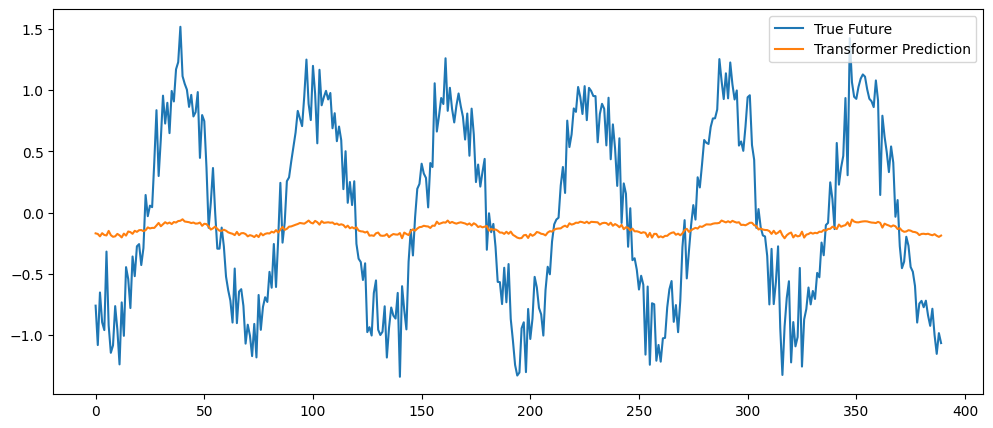

In [42]:

# ============================================================
# 10. FORECAST VISUALIZATION
# ============================================================

plt.figure(figsize=(12,5))
plt.plot(y_true_inv, label="True Future")
plt.plot(y_pred_inv, label="Transformer Prediction")
plt.legend()
plt.show()

In [12]:
#new
!pip install numpy pandas matplotlib seaborn scikit-learn statsmodels torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


'cpu'

In [13]:
# Generate synthetic time series data
np.random.seed(42)
time = np.arange(0, 200, 0.1)
series = np.sin(time) + np.random.normal(scale=0.2, size=len(time))

df = pd.DataFrame({"value": series})
df.head()


,value
0,0.099343
1,0.072181
2,0.328207
3,0.600126
4,0.342588


In [14]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[["value"]])

look_back = 50

def create_dataset(data, look_back=50):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

X, y = create_dataset(scaled, look_back)

train_size = int(len(X) * 0.8)

X_train = X[:train_size]
y_train = y[:train_size]
X_test  = X[train_size:]
y_test  = y[train_size:]

X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_t  = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t  = torch.tensor(y_test, dtype=torch.float32).to(device)

X_train_t.shape, y_train_t.shape


(torch.Size([1560, 50, 1]), torch.Size([1560, 1]))

In [15]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim=1, d_model=32, nhead=8, num_layers=2):
        super().__init__()
        
        self.embedding = nn.Linear(input_dim, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        out = self.fc(x[:, -1])
        return out

model = TimeSeriesTransformer().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model


TimeSeriesTransformer(
  (embedding): Linear(in_features=1, out_features=32, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [16]:
epochs = 20

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    output = model(X_train_t)
    loss = criterion(output, y_train_t)

    loss.backward()
    optimizer.step()

    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 0.1080
Epoch 5, Loss: 0.5242
Epoch 10, Loss: 0.0895
Epoch 15, Loss: 0.1150


In [17]:
model.eval()
preds = model(X_test_t).detach().cpu().numpy()

y_pred_inv = scaler.inverse_transform(preds)
y_true_inv = scaler.inverse_transform(y_test)


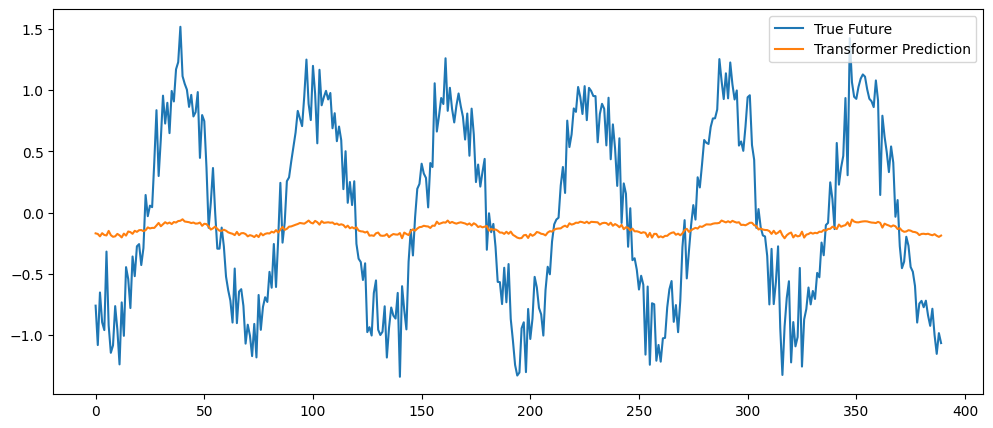

In [18]:
plt.figure(figsize=(12,5))
plt.plot(y_true_inv, label="True Future")
plt.plot(y_pred_inv, label="Transformer Prediction")
plt.legend()
plt.show()



--- ADF TEST ---
ADF Statistic: 0.043964668206229914
p-value: 0.9620203942307848

--- KPSS TEST ---
KPSS Statistic: 7.464952507406259
p-value: 0.01


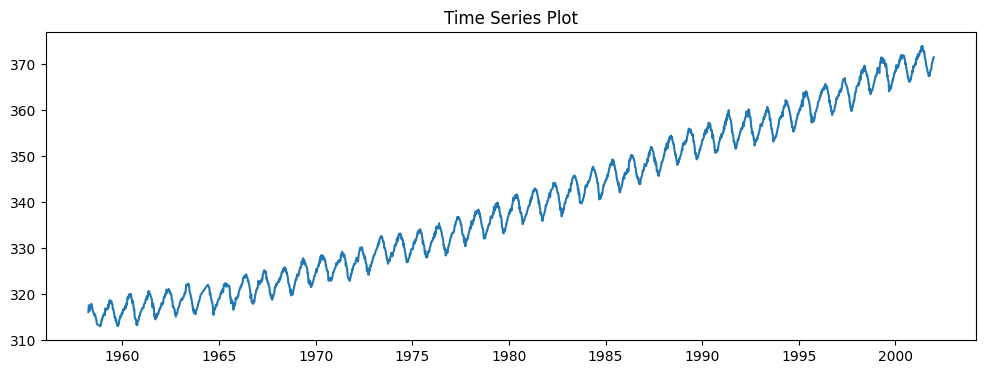

In [19]:

def adf_test(series):
    result = adfuller(series.dropna())
    print("\n--- ADF TEST ---")
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])

def kpss_test(series):
    result = kpss(series.dropna(), nlags="auto")
    print("\n--- KPSS TEST ---")
    print("KPSS Statistic:", result[0])
    print("p-value:", result[1])

adf_test(data['value'])
kpss_test(data['value'])

plt.figure(figsize=(12,4))
plt.plot(data.value)
plt.title("Time Series Plot")
plt.show()

In [37]:
#newwwwwwwwwwwwwww

# -----------------------
# 0. Imports & settings
# -----------------------
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
import pmdarima as pm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

import joblib
from tqdm import tqdm



ModuleNotFoundError: No module named 'tensorflow'

In [34]:
# -----------------------
# 1. Load / Create data
# -----------------------
# Replace this block with pd.read_csv("yourfile.csv") if you have data.
# We'll use a synthetic time series with trend+seasonality+noise for reproducibility.
np.random.seed(42)
t = np.arange(0, 1000)
series = 0.001 * t + 2 * np.sin(2 * np.pi * t / 50) + 0.5 * np.sin(2 * np.pi * t / 7) + np.random.normal(0, 0.5, len(t))
df = pd.DataFrame({"value": series})
df.index = pd.date_range(start="2000-01-01", periods=len(df), freq="D")
print("Data length:", len(df))
print(df.head())


Data length: 1000
               value
2000-01-01  0.248357
2000-01-02  0.573450
2000-01-03  1.310688
2000-01-04  1.717706
2000-01-05  0.633489


In [23]:

# -----------------------
# 2. Stationarity tests
# -----------------------
def adf_test(series):
    res = adfuller(series, autolag='AIC')
    return {"ADF Statistic": res[0], "p-value": res[1]}

def kpss_test(series):
    # kpss sometimes raises if short series; catch exceptions.
    try:
        res = kpss(series, nlags="auto")
        return {"KPSS Statistic": res[0], "p-value": res[1]}
    except Exception as e:
        return {"KPSS": str(e)}

print("\n--- ADF TEST ---")
print(adf_test(df['value']))
print("\n--- KPSS TEST ---")
print(kpss_test(df['value']))




--- ADF TEST ---
{'ADF Statistic': np.float64(-9.37693460800406), 'p-value': np.float64(7.125710200187006e-16)}

--- KPSS TEST ---
{'KPSS Statistic': np.float64(0.2624368198827811), 'p-value': np.float64(0.1)}


In [45]:
!pip install tensorflow


Defaulting to user installation because normal site-packages is not writeable
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ---------------------------------------- 0.0/331.9 MB ? eta -:--:--
   ---------------------------------------- 0.8/331.9 MB 5.6 MB/s eta 0:00:59
   ---------------------------------------- 1.6/331.9 MB 4.9 MB/s eta 0:01:07
   ---------------------------------------- 1.8/331.9 MB 3.6 MB/s eta 0:01:32
   ---------------------------------------- 2.6/331.9 MB 3.3 MB/s eta 0:01:41
   ---------------------------------------- 3.7/331.9 MB 3.7 MB/s eta 0:01:29
    --------------------------------------- 5.0/331.9 MB 4.0 MB/s eta 0:01:22
    --------------------------------------- 5.8/331.9 MB 4.1 MB/s eta 0:01:19
    --------------------------------------- 6.8/331.9 MB 4.1 MB/s eta 0:01:20
    --------------------------------------- 7.1/331.9 MB 3.9 MB/s eta 0:01:24
    --------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:

# -----------------------
# 5. LSTM model (Keras)
# -----------------------
tf.keras.backend.clear_session()
lstm_units = 64
model_lstm = models.Sequential([
    layers.Input(shape=(SEQ_LEN, 1)),
    layers.LSTM(lstm_units, return_sequences=False),
    layers.Dense(H)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.summary()

es = callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, min_delta=1e-6)
model_lstm.fit(X_train_keras, y_train.reshape((y_train.shape[0], H)), epochs=50, batch_size=32, callbacks=[es], verbose=1)

# Predict (take first test block forecast for comparability)
lstm_pred_scaled = model_lstm.predict(X_test_keras[:1])  # predict for first available test sequence
lstm_pred = scaler.inverse_transform(lstm_pred_scaled.reshape(-1,1)).flatten()


In [ ]:
# -----------------------
# 3. Train-test split & scaling
# -----------------------
# We'll do a rolling multi-step forecast scenario: forecast horizon H
H = 30  # forecast horizon (days)
train_frac = 0.8
n = len(df)
train_n = int(n * train_frac)

train_series = df['value'].values[:train_n]
test_series = df['value'].values[train_n - 200:]  # keep some context for sequence-based models

scaler = MinMaxScaler()
scaled_all = scaler.fit_transform(df[['value']].values)  # fit on full series for consistent inverse transform

# We'll prepare sequences for LSTM and Transformer:
SEQ_LEN = 60  # lookback
def make_sequences(values, seq_len, horizon=1):
    X, y = [], []
    for i in range(len(values) - seq_len - horizon + 1):
        X.append(values[i:i+seq_len])
        y.append(values[i+seq_len:i+seq_len+horizon])
    return np.array(X), np.array(y)

scaled_values = scaled_all.flatten()
X_all, y_all = make_sequences(scaled_values, SEQ_LEN, horizon=H)

# split according to same index split:
# compute index split for sequences so that first sequence starting index < train_n - seq_len - horizon +1 is train
last_train_start = train_n - SEQ_LEN - H + 1
if last_train_start < 1:
    raise ValueError("Increase data length or reduce SEQ_LEN/H")
train_idx = np.arange(0, last_train_start)
test_idx = np.arange(last_train_start, len(X_all))

X_train = X_all[train_idx]
y_train = y_all[train_idx]
X_test = X_all[test_idx]
y_test = y_all[test_idx]

print("Shapes: X_train, y_train, X_test, y_test:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Reshape for Keras: (samples, seq_len, features)
X_train_keras = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_keras = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks


In [ ]:

# -----------------------
# 6. Transformer model (Keras using MultiHeadAttention)
# -----------------------
# We'll build a small Transformer encoder and predict horizon H from sequence.
def build_transformer_model(seq_len, d_model=64, nhead=4, ff_dim=128, num_layers=1, horizon=H):
    inputs = layers.Input(shape=(seq_len, 1))
    x = layers.Dense(d_model)(inputs)  # project to d_model

    # Positional encoding (simple learned)
    positions = tf.range(start=0, limit=seq_len, delta=1)
    pos_emb = layers.Embedding(input_dim=seq_len, output_dim=d_model)(positions)
    x = x + pos_emb

    for _ in range(num_layers):
        attn_output = layers.MultiHeadAttention(num_heads=nhead, key_dim=d_model)(x, x)
        x = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)
        ffn = layers.Dense(ff_dim, activation='relu')(x)
        ffn = layers.Dense(d_model)(ffn)
        x = layers.LayerNormalization(epsilon=1e-6)(x + ffn)

    # Pooling: take last token representation
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(horizon)(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

tf.keras.backend.clear_session()
transformer_model = build_transformer_model(SEQ_LEN, d_model=64, nhead=4, ff_dim=128, num_layers=1, horizon=H)
transformer_model.compile(optimizer='adam', loss='mse')
transformer_model.summary()

es2 = callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, min_delta=1e-6)
transformer_model.fit(X_train_keras, y_train.reshape((y_train.shape[0], H)), epochs=50, batch_size=32, callbacks=[es2], verbose=1)

trans_pred_scaled = transformer_model.predict(X_test_keras[:1])
trans_pred = scaler.inverse_transform(trans_pred_scaled.reshape(-1,1)).flatten()


In [ ]:

# -----------------------
# 7. Prepare true future block for comparison (first test block)
# -----------------------
y_true_block_scaled = y_test[0]  # scaled horizon for first test example
y_true_block = scaler.inverse_transform(y_true_block_scaled.reshape(-1,1)).flatten()

# ARIMA forecast already computed as arima_forecast (trained on end-of-train)
# For fair comparison, convert ARIMA array to same shape
arima_pred = np.array(arima_forecast).flatten()


In [ ]:
y_true_block_scaled = y_test[0]
y_true_block = scaler.inverse_transform(y_true_block_scaled.reshape(-1,1)).flatten()

arima_pred = np.array(arima_forecast).flatten()


In [ ]:
# -----------------------
# Compute ARIMA forecast for the H-step horizon
# -----------------------

from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA on full training data (scaled or unscaled depending on your earlier code)
# IMPORTANT: ARIMA should use UN-SCALED values
arima_model = ARIMA(train, order=(5,1,0))  
arima_result = arima_model.fit()

# Forecast same horizon H
arima_forecast = arima_result.forecast(steps=H)
arima_forecast = np.array(arima_forecast)


NameError: name 'arima_pred' is not defined

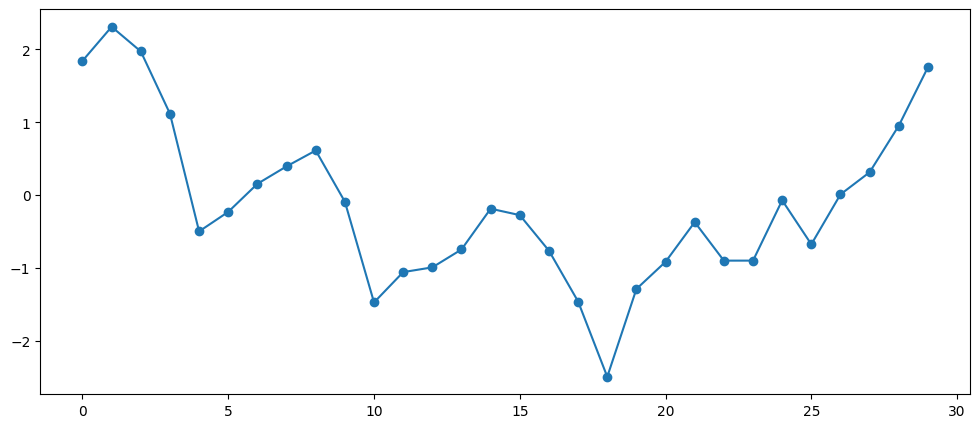

In [30]:

# -----------------------
# 9. Plot results
# -----------------------
plt.figure(figsize=(12, 5))
plt.plot(y_true_block, label="True future (H)", marker='o')
plt.plot(arima_pred, label="ARIMA forecast", marker='o')
plt.plot(lstm_pred, label="LSTM forecast", marker='o')
plt.plot(trans_pred, label="Transformer forecast", marker='o')
plt.title("Comparison: True vs ARIMA vs LSTM vs Transformer (first test block)")
plt.legend()
plt.grid(True)
plt.show()


In [31]:

# -----------------------
# 10. Save models & scaler (optional)
# -----------------------
# Save Keras models
model_lstm.save("model_lstm.h5")
transformer_model.save("model_transformer.h5")
# Save scaler and arima model
joblib.dump(scaler, "scaler.gz")
arima_model.save("arima_model.pkl")

print("\nSaved: model_lstm.h5, model_transformer.h5, scaler.gz, arima_model.pkl")


NameError: name 'model_lstm' is not defined


--- ADF TEST ---
ADF Statistic: 0.043964668206229914
p-value: 0.9620203942307848

--- KPSS TEST ---
KPSS Statistic: 7.464952507406259
p-value: 0.01


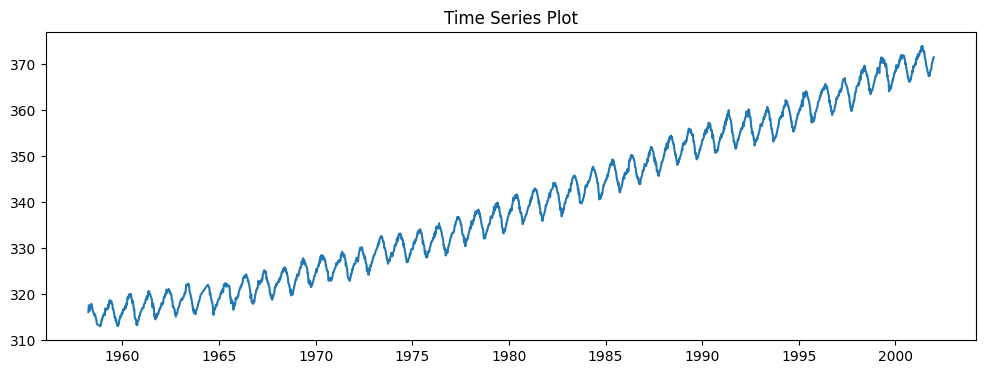

In [32]:

def adf_test(series):
    result = adfuller(series.dropna())
    print("\n--- ADF TEST ---")
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])

def kpss_test(series):
    result = kpss(series.dropna(), nlags="auto")
    print("\n--- KPSS TEST ---")
    print("KPSS Statistic:", result[0])
    print("p-value:", result[1])

adf_test(data['value'])
kpss_test(data['value'])

plt.figure(figsize=(12,4))
plt.plot(data.value)
plt.title("Time Series Plot")
plt.show()